In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torchvision.datasets import mnist
import numpy as np
from torch.utils.data import DataLoader
# 使用 pytorch 自带的 DataLoader 定义一个数据迭代器

In [2]:
train_set = mnist.MNIST('./data', train=True, download=True)
test_set = mnist.MNIST('./data', train=False, download=True)

In [3]:
class simplenetwork(nn.Module):
    def __init__(self, in_dim, n_hidden1, n_hidden2, out_dim):
        super(simplenetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_dim, n_hidden1), 
            nn.BatchNorm1d(n_hidden1),
            nn.ReLU(True)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(n_hidden1, n_hidden2),
            nn.BatchNorm1d(n_hidden2),
            nn.ReLU(True)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(n_hidden2, out_dim)
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [4]:
data, label = train_set[0]
print(data, label)

<PIL.Image.Image image mode=L size=28x28 at 0x234EDB66AC8> tensor(5)


In [5]:
data = np.array(data, dtype='float')
print(data.shape)

def data_tf(x):
    x = np.array(x, dtype='float') / 255
    # 标准化
    x = (x - 0.5) / 0.5
    x = x.reshape((-1, ))
    x = torch.from_numpy(x)
    return x
# 这里我们可以重新载入数据集，并声明定义的数据变换
train_set = mnist.MNIST('./data', train=True, transform=data_tf, download=True) 
test_set = mnist.MNIST('./data', train=False, transform=data_tf, download=True)

(28, 28)


In [6]:
# 使用这样的数据迭代器是非常有必要的，如果数据量太大，就无法一次将他们全部读入内存，所以需要使用 python 迭代器，每次生成一个批次的数据
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data = DataLoader(test_set, batch_size=128, shuffle=False)
print(type(train_data))

<class 'torch.utils.data.dataloader.DataLoader'>


In [7]:
a, a_label = next(iter(train_data))
# 打印出一个批次的数据大小
print(a.shape)
print(a_label.shape)

torch.Size([64, 784])
torch.Size([64])


In [8]:
model = simplenetwork(28 * 28, 300, 100, 10)
# model = model.cuda()
# 定义损失函数
criterion = nn.CrossEntropyLoss()
# 随机梯度下降。学习率为0.1
optimizer = optim.SGD(model.parameters(), 1e-1)

In [9]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []

for e in range(20):
    train_loss = 0
    train_acc = 0
    model.train()
    for im, label in train_data:
        im = Variable(im, volatile=True)
        label = Variable(label, volatile=True)
        # 前向传播
        im = im.float()
        out = model(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    model.eval() # 将模型改为预测模式
    for im, label in test_data:
        im = Variable(im)
        label = Variable(label)
        im = im.float()
        out = model(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))

epoch: 0, Train Loss: 0.261108, Train Acc: 0.933436, Eval Loss: 0.104968, Eval Acc: 0.968750
epoch: 1, Train Loss: 0.097779, Train Acc: 0.970732, Eval Loss: 0.082281, Eval Acc: 0.975376
epoch: 2, Train Loss: 0.066752, Train Acc: 0.979511, Eval Loss: 0.089321, Eval Acc: 0.971816
epoch: 3, Train Loss: 0.051378, Train Acc: 0.983959, Eval Loss: 0.075787, Eval Acc: 0.976760
epoch: 4, Train Loss: 0.041249, Train Acc: 0.987024, Eval Loss: 0.058155, Eval Acc: 0.982595
epoch: 5, Train Loss: 0.032154, Train Acc: 0.990022, Eval Loss: 0.058410, Eval Acc: 0.981210
epoch: 6, Train Loss: 0.025900, Train Acc: 0.992138, Eval Loss: 0.070391, Eval Acc: 0.976760
epoch: 7, Train Loss: 0.022331, Train Acc: 0.992837, Eval Loss: 0.071222, Eval Acc: 0.979430
epoch: 8, Train Loss: 0.019196, Train Acc: 0.993653, Eval Loss: 0.071409, Eval Acc: 0.979233
epoch: 9, Train Loss: 0.017342, Train Acc: 0.994819, Eval Loss: 0.061864, Eval Acc: 0.981705
epoch: 10, Train Loss: 0.012281, Train Acc: 0.996768, Eval Loss: 0.058

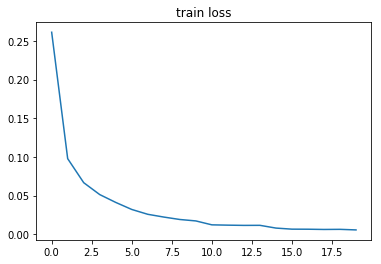

In [11]:
import matplotlib.pyplot as plt
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
plt.show()

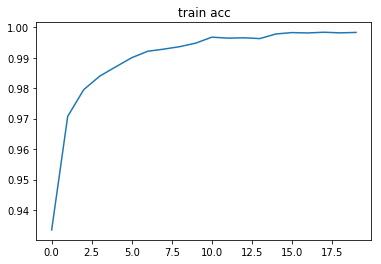

In [12]:
plt.plot(np.arange(len(acces)), acces)
plt.title('train acc')
plt.show()

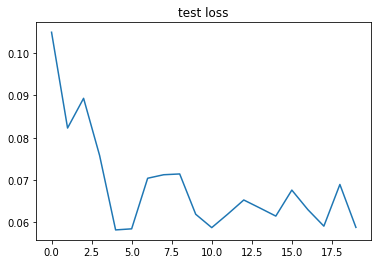

In [13]:
plt.plot(np.arange(len(eval_losses)), eval_losses)
plt.title('test loss')
plt.show()

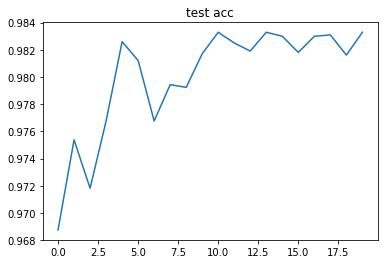

In [14]:
plt.plot(np.arange(len(eval_acces)), eval_acces)
plt.title('test acc')
plt.show()